In [19]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [20]:

# CONFIGURATION
FEATURE_LABELS = [
    "id1", "cell", "step", "id2", "count", "date", "clock",
    "t_min", "V_mV", "I_mA", "Q_mAh", "E_mWh", "P_W"
]

MANUFACTURER_FILE_PATTERNS = {
    'Manufacturer_A': ['27_'],
    'Manufacturer_B': ['21_'],
    'Manufacturer_C': ['10_', '11_']
}

In [21]:

# Data loading

def read_single_battery_file(file_path):
    """Read individual battery test file with metadata."""
    battery_data = pd.read_csv(file_path, header=None, sep=r'\s+')
    battery_data.columns = FEATURE_LABELS
    battery_data["file_origin"] = file_path.name
    return battery_data

def aggregate_manufacturer_data(pattern_list, directory_path="."):
    """
    Combine all battery test files matching specified patterns.

    Parameters:
        pattern_list: File name patterns to match
        directory_path: Source directory for data files

    Returns:
        Combined DataFrame with all matching files
    """
    search_dir = Path(directory_path)
    collected_data = []

    for pattern in pattern_list:
        file_matches = sorted(search_dir.glob(f"{pattern}*.txt"))
        for matched_file in file_matches:
            file_data = read_single_battery_file(matched_file)
            collected_data.append(file_data)

    if len(collected_data) == 0:
        return pd.DataFrame(columns=FEATURE_LABELS + ["file_origin"])

    return pd.concat(collected_data, ignore_index=True)


In [22]:

# Battery Analysis

def extract_discharge_steps(battery_dataframe):
    """
    Find test steps where battery discharging occurs.

    Parameters:
        battery_dataframe: Complete battery test data

    Returns:
        List of step IDs with discharge activity (negative current)
    """
    step_current_analysis = battery_dataframe.groupby("step")["I_mA"].agg(['min', 'max'])
    discharge_step_ids = step_current_analysis[step_current_analysis['min'] < 0].index.tolist()
    return discharge_step_ids

def compute_performance_metrics(test_data, discharge_step_list):
    """
    Calculate comprehensive performance metrics for each battery cell.

    Parameters:
        test_data: Raw battery test measurements
        discharge_step_list: Steps identified as discharge phases

    Returns:
        Aggregated metrics per cell
    """
    filtered_discharge = test_data[test_data["step"].isin(discharge_step_list)].copy()

    cell_performance = filtered_discharge.groupby("cell").agg(
        max_capacity_mAh=("Q_mAh", "max"),
        total_energy_mWh=("E_mWh", "max"),
        max_power_W=("P_W", "max"),
        start_time_min=("t_min", "min"),
        end_time_min=("t_min", "max"),
        init_voltage_V=("V_mV", lambda x: x.iloc[0] / 1000),
        mean_voltage_V=("V_mV", lambda x: x.mean() / 1000),
        mean_current_A=("I_mA", lambda x: x.mean() / 1000),
        mean_power_W=("P_W", "mean")
    )

    cell_performance["duration_min"] = (cell_performance["end_time_min"] -
                                        cell_performance["start_time_min"])

    return cell_performance

def append_health_metrics(performance_df, q_percentile=95, e_percentile=95):
    """
    Add normalized health indicators to cell performance data.

    Parameters:
        performance_df: Cell performance metrics
        q_percentile: Reference percentile for capacity normalization
        e_percentile: Reference percentile for energy normalization

    Returns:
        Enhanced dataframe with SOH/SOP, reference capacity, reference energy
    """
    baseline_capacity = np.percentile(performance_df["max_capacity_mAh"], q_percentile)
    baseline_energy = np.percentile(performance_df["total_energy_mWh"], e_percentile)

    augmented_df = performance_df.copy()
    augmented_df["state_of_health"] = augmented_df["max_capacity_mAh"] / baseline_capacity
    augmented_df["state_of_power"] = augmented_df["total_energy_mWh"] / baseline_energy

    return augmented_df, baseline_capacity, baseline_energy


In [24]:
import matplotlib.pyplot as plt

# VISUALIZATION MODULE

def visualize_capacity_comparison(manufacturer_dict, num_bins=40, plot_size=(12, 6)):
    """
    Create comparative histogram showing capacity distributions.

    Parameters:
        manufacturer_dict: Dictionary with manufacturer names as keys
        num_bins: Histogram bin count
        plot_size: Figure dimensions
    """
    fig, ax = plt.subplots(figsize=plot_size)

    for mfr_name, mfr_data in manufacturer_dict.items():
        ax.hist(mfr_data["max_capacity_mAh"], bins=num_bins,
                alpha=0.5, label=mfr_name, edgecolor='black', linewidth=0.5)

    ax.set_xlabel("Discharge Capacity (mAh)", fontsize=12)
    ax.set_ylabel("Cell Count", fontsize=12)
    ax.set_title("Capacity Distribution Comparison Across Manufacturers", fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


In [25]:

# MACHINE LEARNING - RANDOM FOREST WITH HYPERPARAMETER OPTIMIZATION

def define_rf_search_space():
    """Configure hyperparameter search grid for Random Forest."""
    param_space = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }
    return param_space

def custom_mape_scorer(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def optimize_and_evaluate_model(X_train, y_train, n_cv_folds=5, seed=42):
    """
    Perform hyperparameter tuning and model evaluation.

    Parameters:
        X_train: Feature matrix
        y_train: Target values
        n_cv_folds: Cross-validation fold count
        seed: Random state for reproducibility

    Returns:
        Dictionary with optimized model and performance metrics
    """
    # Initialize base estimator
    rf_estimator = RandomForestRegressor(random_state=seed, n_jobs=-1)

    # Setup hyperparameter search
    grid_optimizer = GridSearchCV(
        estimator=rf_estimator,
        param_grid=define_rf_search_space(),
        cv=n_cv_folds,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    # Execute grid search
    print("  Initiating hyperparameter optimization...")
    grid_optimizer.fit(X_train, y_train)

    # Extract best model
    optimized_model = grid_optimizer.best_estimator_

    # Define custom scoring functions
    scoring_metrics = {
        'neg_mse': 'neg_mean_squared_error',
        'neg_mae': 'neg_mean_absolute_error',
        'r2': 'r2'
    }

    # Perform cross-validation with best model
    cv_results = cross_validate(
        optimized_model, X_train, y_train,
        cv=n_cv_folds,
        scoring=scoring_metrics,
        return_train_score=False
    )

    # Calculate performance metrics
    rmse_score = np.sqrt(-cv_results['test_neg_mse'].mean())
    mae_score = -cv_results['test_neg_mae'].mean()
    r2_score = cv_results['test_r2'].mean()

    # Calculate MAPE manually
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(optimized_model, X_train, y_train, cv=n_cv_folds)
    mape_score = custom_mape_scorer(y_train, predictions)

    results_package = {
        'model': optimized_model,
        'best_params': grid_optimizer.best_params_,
        'rmse': rmse_score,
        'mae': mae_score,
        'mape': mape_score,
        'r2': r2_score,
        'cv_results': grid_optimizer.cv_results_
    }

    return results_package


In [26]:
# Load battery test data from all manufacturers
print("LOADING BATTERY TEST DATA")

manufacturer_datasets = {}
for mfr_label, file_patterns in MANUFACTURER_FILE_PATTERNS.items():
    manufacturer_datasets[mfr_label] = aggregate_manufacturer_data(file_patterns)
    record_count = manufacturer_datasets[mfr_label].shape[0]
    print(f"{mfr_label}: {record_count:,} test records loaded")

print(f"\nTotal manufacturers analyzed: {len(manufacturer_datasets)}")

LOADING BATTERY TEST DATA
Manufacturer_A: 381,364 test records loaded
Manufacturer_B: 527,113 test records loaded
Manufacturer_C: 583,593 test records loaded

Total manufacturers analyzed: 3


In [27]:
#  Identify discharge test phases for each manufacturer
print("IDENTIFYING DISCHARGE PHASES")

discharge_phase_map = {}
for mfr_label, dataset in manufacturer_datasets.items():
    discharge_phase_map[mfr_label] = extract_discharge_steps(dataset)
    print(f"{mfr_label} discharge steps: {discharge_phase_map[mfr_label]}")




IDENTIFYING DISCHARGE PHASES
Manufacturer_A discharge steps: [3]
Manufacturer_B discharge steps: [3]
Manufacturer_C discharge steps: [5]


In [28]:
# Calculate cell-level performance metrics
print("\n" + "=" * 80)
print("COMPUTING CELL PERFORMANCE METRICS")
print("=" * 80)

cell_metrics_by_mfr = {}
for mfr_label, dataset in manufacturer_datasets.items():
    cell_metrics_by_mfr[mfr_label] = compute_performance_metrics(
        dataset,
        discharge_phase_map[mfr_label]
    )
    cell_count = len(cell_metrics_by_mfr[mfr_label])
    print(f"{mfr_label}: {cell_count} cells analyzed")
    print(f"  Average capacity: {cell_metrics_by_mfr[mfr_label]['max_capacity_mAh'].mean():.1f} mAh")
    print(f"  Capacity std dev: {cell_metrics_by_mfr[mfr_label]['max_capacity_mAh'].std():.1f} mAh")


COMPUTING CELL PERFORMANCE METRICS
Manufacturer_A: 256 cells analyzed
  Average capacity: 4994.5 mAh
  Capacity std dev: 1426.7 mAh
Manufacturer_B: 256 cells analyzed
  Average capacity: 4733.9 mAh
  Capacity std dev: 83.6 mAh
Manufacturer_C: 256 cells analyzed
  Average capacity: 4577.3 mAh
  Capacity std dev: 84.0 mAh


CALCULATING HEALTH INDICATORS

Manufacturer_A:
  Reference Capacity: 10047.8 mAh
  Reference Energy: 17311.3 mWh
  Mean SOH: 0.4971
  Mean SOP: 0.9675

Manufacturer_B:
  Reference Capacity: 4826.0 mAh
  Reference Energy: 17628.4 mWh
  Mean SOH: 0.9809
  Mean SOP: 0.9795

Manufacturer_C:
  Reference Capacity: 4714.0 mAh
  Reference Energy: 17041.3 mWh
  Mean SOH: 0.9710
  Mean SOP: 0.9722
GENERATING VISUALIZATIONS


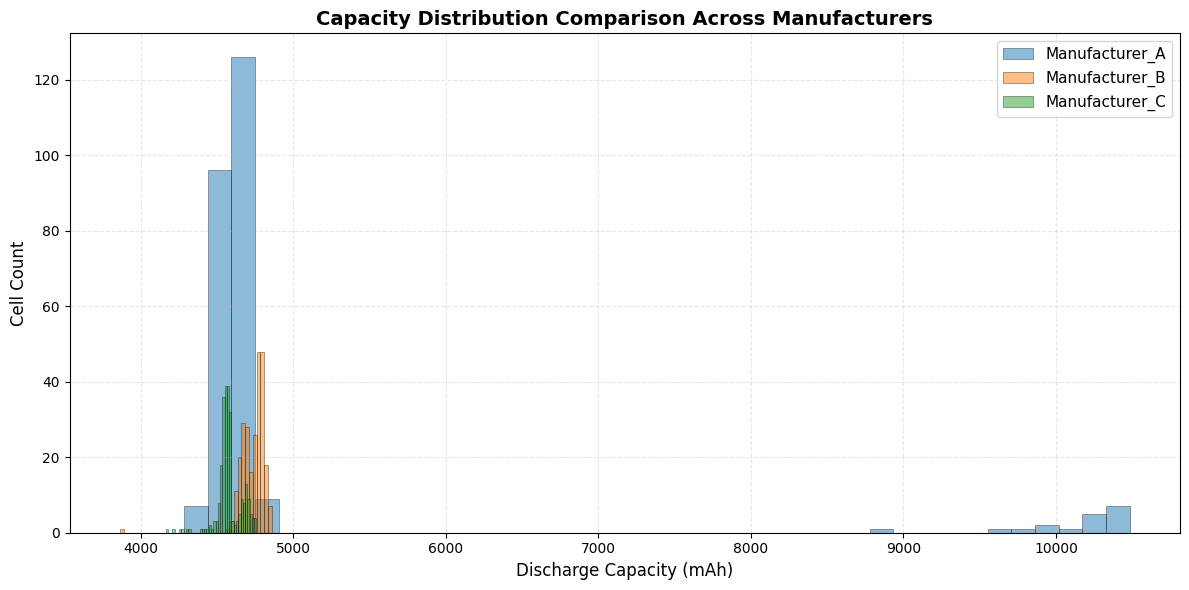

In [30]:
#Add health indicators (SOH/SOP)
print("CALCULATING HEALTH INDICATORS")

health_augmented_data = {}
reference_values = {}

for mfr_label, metrics in cell_metrics_by_mfr.items():
    augmented, ref_q, ref_e = append_health_metrics(metrics)
    health_augmented_data[mfr_label] = augmented
    reference_values[mfr_label] = {'capacity': ref_q, 'energy': ref_e}

    print(f"\n{mfr_label}:")
    print(f"  Reference Capacity: {ref_q:.1f} mAh")
    print(f"  Reference Energy: {ref_e:.1f} mWh")
    print(f"  Mean SOH: {augmented['state_of_health'].mean():.4f}")
    print(f"  Mean SOP: {augmented['state_of_power'].mean():.4f}")

# Visualize capacity distributions
print("GENERATING VISUALIZATIONS")

visualize_capacity_comparison(cell_metrics_by_mfr)


In [31]:
# Prepare data for machine learning (focus on best manufacturer)
print("PREPARING ML TRAINING DATA")

# Select manufacturer with best performance (highest average capacity)
best_manufacturer = max(
    cell_metrics_by_mfr.keys(),
    key=lambda x: cell_metrics_by_mfr[x]['max_capacity_mAh'].mean()
)

print(f"Selected manufacturer for modeling: {best_manufacturer}")

# Define feature set
predictor_features = [
    "duration_min",
    "init_voltage_V",
    "mean_voltage_V",
    "mean_current_A",
    "mean_power_W"
]

# Prepare feature matrix and target variables
X_matrix = health_augmented_data[best_manufacturer][predictor_features].values
y_soh_target = health_augmented_data[best_manufacturer]["state_of_health"].values
y_sop_target = health_augmented_data[best_manufacturer]["state_of_power"].values

print(f"Feature matrix shape: {X_matrix.shape}")
print(f"Target variables prepared: SOH and SOP")

PREPARING ML TRAINING DATA
Selected manufacturer for modeling: Manufacturer_A
Feature matrix shape: (256, 5)
Target variables prepared: SOH and SOP


In [32]:
#  Train SOH prediction model with hyperparameter tuning
print("TRAINING SOH PREDICTION MODEL")

soh_results = optimize_and_evaluate_model(X_matrix, y_soh_target)

print("\nSOH Model Results ")
print(f"Best Hyperparameters:")
for param_name, param_value in soh_results['best_params'].items():
    print(f"  {param_name}: {param_value}")

print(f"\nPerformance Metrics (5-fold CV):")
print(f"  RMSE: {soh_results['rmse']:.6f}")
print(f"  MAE:  {soh_results['mae']:.6f}")
print(f"  MAPE: {soh_results['mape']:.3f}%")
print(f"  R²:   {soh_results['r2']:.4f}")

TRAINING SOH PREDICTION MODEL
  Initiating hyperparameter optimization...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

SOH Model Results 
Best Hyperparameters:
  bootstrap: False
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 100

Performance Metrics (5-fold CV):
  RMSE: 0.022700
  MAE:  0.009291
  MAPE: 1.538%
  R²:   0.9751


In [33]:
# Train SOP prediction model with hyperparameter tuning
print("\n")
print("TRAINING SOP PREDICTION MODEL")

sop_results = optimize_and_evaluate_model(X_matrix, y_sop_target)

print("\n SOP Model Results")
print(f"Best Hyperparameters:")
for param_name, param_value in sop_results['best_params'].items():
    print(f"  {param_name}: {param_value}")

print(f"\nPerformance Metrics (5-fold CV):")
print(f"  RMSE: {sop_results['rmse']:.6f}")
print(f"  MAE:  {sop_results['mae']:.6f}")
print(f"  MAPE: {sop_results['mape']:.3f}%")
print(f"  R²:   {sop_results['r2']:.4f}")




TRAINING SOP PREDICTION MODEL
  Initiating hyperparameter optimization...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

 SOP Model Results
Best Hyperparameters:
  bootstrap: True
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 200

Performance Metrics (5-fold CV):
  RMSE: 0.013200
  MAE:  0.009606
  MAPE: 0.998%
  R²:   0.5914


In [34]:
# Summary and conclusions
print("Final Analysis")

print(f"\nBest Performing Manufacturer: {best_manufacturer}")
print(f"  Cells Analyzed: {len(health_augmented_data[best_manufacturer])}")
print(f"  Average Capacity: {cell_metrics_by_mfr[best_manufacturer]['max_capacity_mAh'].mean():.1f} mAh")

print("\nModel Performance Summary:")
print(f"  SOH Prediction Error: {soh_results['mape']:.2f}%")
print(f"  SOP Prediction Error: {sop_results['mape']:.2f}%")



Final Analysis

Best Performing Manufacturer: Manufacturer_A
  Cells Analyzed: 256
  Average Capacity: 4994.5 mAh

Model Performance Summary:
  SOH Prediction Error: 1.54%
  SOP Prediction Error: 1.00%
